In [1]:
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

from pylab import *
import pyart, boto3, tempfile, os, shutil, datetime, matplotlib
import pyart
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from time import time
import netCDF4
import os
import cartopy.crs as ccrs
import matplotlib.colors as colors
from skewt import SkewT
from glob import glob
from botocore.handlers import disable_signing
import csu_radartools
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\iac6311\AppData\Local\Continuum\anaconda3\envs\saveurproj\lib\site-packages\botocore\vendored\requests\packages\urllib3\_collections.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping, MutableMapping


In [2]:
def get_radar_scan(station='KLOT', date=None, key_index=-20):
    
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    Station = Four letter NEXRAD identifier
              Example: 'KEPZ'
    Date = default is none for current date, else enter date in format "YYYY/MM/DD"
    Ex: date ='2013/11/17
    Key_index = Number of keys you want pulled from most recent scan.
    Ex: key_index = -15 would pull ht most recent 15 scans
    '''
    
    # Creating a bucket and a client to be able to pull data from AWS and setting it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    # Connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    # Setting the date and time to current...
    # This will allow for allow the current date's radar scands to be pulled
    if date == None:
        target_string = datetime.datetime.utcnow().strftime('%Y/%m/%d/'+station)
    else:
        target_string = date+'/'+station
    
    for obj in aws_radar.objects.filter(Prefix= target_string):
        '{0}:{1}'.format(aws_radar.name, obj.key)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]
    keys = my_list_of_keys[key_index:]
    for key in keys:
        if 'MDM' in key:
            keys.remove(key)
    print(keys)
    return aws_radar, keys

In [3]:
# Setting radar, date of radar scans needed, and key index (amount of items in list)
aws_radar, keys = get_radar_scan(station='KLOT', date='2019/06/27', key_index=-400) 
out_path_dir = './out/'

['2019/06/27/KLOT/KLOT20190627_000513_V06', '2019/06/27/KLOT/KLOT20190627_001050_V06', '2019/06/27/KLOT/KLOT20190627_001627_V06', '2019/06/27/KLOT/KLOT20190627_002203_V06', '2019/06/27/KLOT/KLOT20190627_002741_V06', '2019/06/27/KLOT/KLOT20190627_003318_V06', '2019/06/27/KLOT/KLOT20190627_003854_V06', '2019/06/27/KLOT/KLOT20190627_004438_V06', '2019/06/27/KLOT/KLOT20190627_005015_V06', '2019/06/27/KLOT/KLOT20190627_005559_V06', '2019/06/27/KLOT/KLOT20190627_010144_V06', '2019/06/27/KLOT/KLOT20190627_010728_V06', '2019/06/27/KLOT/KLOT20190627_011304_V06', '2019/06/27/KLOT/KLOT20190627_011857_V06', '2019/06/27/KLOT/KLOT20190627_012449_V06', '2019/06/27/KLOT/KLOT20190627_013033_V06', '2019/06/27/KLOT/KLOT20190627_013647_V06', '2019/06/27/KLOT/KLOT20190627_014301_V06', '2019/06/27/KLOT/KLOT20190627_014913_V06', '2019/06/27/KLOT/KLOT20190627_015526_V06', '2019/06/27/KLOT/KLOT20190627_020111_V06', '2019/06/27/KLOT/KLOT20190627_020654_V06', '2019/06/27/KLOT/KLOT20190627_021237_V06', '2019/06/2

In [4]:
# Pulling a specific amount of scans and assigning them to variable "nk":
nk = keys[20]
nk

'2019/06/27/KLOT/KLOT20190627_020111_V06'

In [5]:
# open a temporary local file
localfile = tempfile.NamedTemporaryFile(delete=False)
localfile_name = localfile.name
localfile.close()

# download to temporary file and read to radar object using pyart
aws_radar.download_file(keys[20], localfile_name)
radar = pyart.io.read(localfile_name)

# delete temporary file to save space
os.remove(localfile_name)

In [6]:
def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13,5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display

In [23]:
ncp_data = np.ones(radar.fields['reflectivity']['data'].shape)
ncp_dict = pyart.config.get_metadata('normalized_coherent_power')
ncp_dict['data'] = ncp_data
radar.add_field('normalized_coherent_power', ncp_dict)

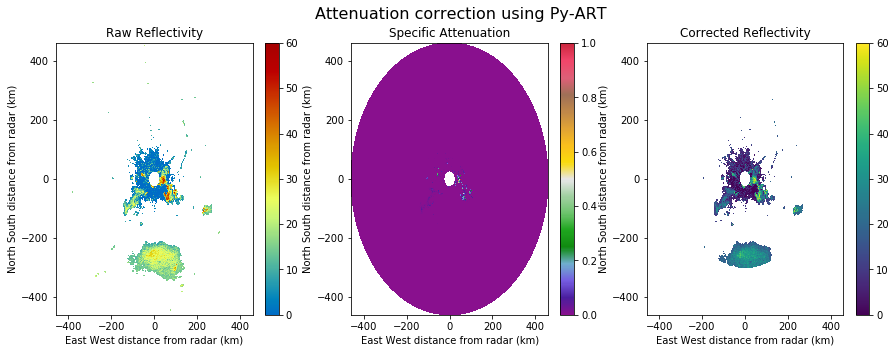

In [28]:
#RADAR_NAME = keys[20]

# read in the data
# radar = pyart.io.read(localfile_name)

# remove existing corrections
try:
    radar.fields.pop('specific_attenuation')
    radar.fields.pop('corrected_reflectivity_horizontal')
except KeyError:
    pass

# perform attenuation correction
spec_at, cor_z = pyart.correct.calculate_attenuation(
    radar, 0, refl_field='reflectivity',
    ncp_field='normalized_coherent_power', 
    rhv_field='cross_correlation_ratio',
    phidp_field='differential_phase'
    )
radar.add_field('specific_attenuation', spec_at)
radar.add_field('corrected_reflectivity_horizontal', cor_z)

# create the plot
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
display = pyart.graph.RadarDisplay(radar)
display.plot('reflectivity', 0, ax=ax1, vmin=0, vmax=60.,
             colorbar_label='', title='Raw Reflectivity')

ax2 = fig.add_subplot(132)
display.plot('specific_attenuation', 0, vmin=0, vmax=1.0,
             colorbar_label='', ax=ax2, title='Specific Attenuation')

ax3 = fig.add_subplot(133)
display = pyart.graph.RadarDisplay(radar)
display.plot('corrected_reflectivity_horizontal', 0, vmin=0, vmax=60.,
             colorbar_label='', ax=ax3, title='Corrected Reflectivity')

plt.suptitle('Attenuation correction using Py-ART', fontsize=16)
plt.show()